# ImageNet classification
This notebook shows an example of ImageNet classification 
The network that is used for inference is a variant of DoReFaNet, whose topology is illustrated in the following picture.
The pink layers are executed in the Programmable Logic at reduced precision (1 bit for weights, 2 bit for activations) while the other layers are executed in python.

This notebook shows how to classify labeled images (extracted from the dataset), while [dorefanet-classification](./dorefanet-classification.ipynb) runs the classification on images choosen by the user

![DoReFaNet topology](dorefanet-topology.svg)

In [1]:
import os, pickle, random
from datetime import datetime
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

import numpy as np
import cv2

import qnn
from qnn import Dorefanet
from qnn import utils

## 1. Instantiate a Classifier
Creating a classifier will automatically download the bitstream onto the device, allocate memory buffers and load the network hyperparameters and weights. 
The neural network to be implemented is specified in a json file (*dorefanet-layers.json* in this example)
The weights for the non-offloaded layers are also loaded in a numpy dictionary to be used for execution in python. 

In [2]:
classifier = Dorefanet()
classifier.init_accelerator()
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-layers.json")

conv0_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-conv0.npy', encoding="latin1").item()
fc_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-fc-normalized.npy', encoding='latin1').item()

## 2. Get ImageNet Classes information
Pick the random image from the imagenet-samples folder (image + correct class) and apply preprocessing transformation before inference. Thanks to the naming format adopted in these images (extracted from the validation set), the correct class is also displayed.

In [3]:
with open("imagenet-classes.pkl", 'rb') as f:
    classes = pickle.load(f)
    names = dict((k, classes[k][1].split(',')[0]) for k in classes.keys())
    synsets = dict((classes[k][0], classes[k][1].split(',')[0]) for k in classes.keys())

## 3. Open image to be classified
Pick the random image from the imagenet-test folder (image + correct class) and apply preprocessing transformation before inference.

bullfrog


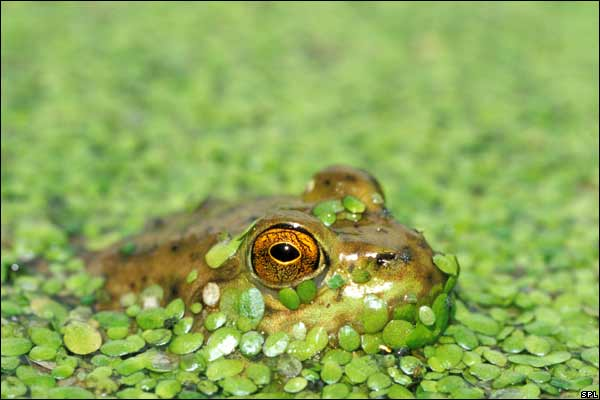

In [4]:
img_folder = './imagenet-samples/'
img_file = os.path.join(img_folder, random.choice(os.listdir(img_folder)))
img, img_class = classifier.load_image(img_file)
im = Image.open(img_file)
if img_class in synsets.keys():
    print(synsets[img_class])
im

## 4. Execute the first convolutional layer in Python
The first layer of this neural network has not been quantized, thus will not be executed in the HW accelerator (which supports only quantized arithmetic). 
Python provides, with numpy, a backend to execute convolution and other matrix operations. For user convenience the most used operations (convolutional layer, thresholding and fully connected layer) are provided in the class.

In [6]:
conv0_W = conv0_weights['conv0/W']
conv0_T = conv0_weights['conv0/T']

start = datetime.now()
# 1st convolutional layer execution, having as input the image and the trained parameters (weights)
conv0 = utils.conv_layer(img, conv0_W, stride=4)
# The result in then quantized to 2 bits representation for the subsequent HW offload
conv0 = utils.threshold(conv0, conv0_T)

end = datetime.now()
micros = int((end - start).total_seconds() * 1000000)
print("First layer SW implementation took {} microseconds".format(micros))
print(micros, file=open('timestamp.txt', 'w'))

First layer SW implementation took 589275 microseconds


### 5. HW Offload of the quantized layers
The core layers, which values have been quantized during training, are executed in the Programmable Logic. The hardware accelerator consists of a dataflow implementation of multiple layers (in this case, convolution+maxpool). 
The host code parses the network topology (specified in the json file) and manages the sequence of execution on the accelerator.

In [7]:
# Compute offloaded convolutional layers
in_dim = net['conv0']['output'][1]
in_ch = net['conv0']['output'][0]
out_dim = net['merge4']['output_dim']
out_ch = net['merge4']['output_channels']

conv_output = classifier.get_accel_buffer(out_ch, out_dim);
conv_input = classifier.prepare_buffer(conv0)

start = datetime.now()
classifier.inference(conv_input, conv_output)
end = datetime.now()

micros = int((end - start).total_seconds() * 1000000)
print("HW implementation took {} microseconds".format(micros))
print(micros, file=open('timestamp.txt', 'a'))

conv_output = classifier.postprocess_buffer(conv_output)

HW implementation took 24243 microseconds


## 6. Fully connected layers in python 
The fully connected layers, are executed in the python backend and the classification finalized

In [8]:
# Normalize results
fc_input = conv_output / np.max(conv_output)

start = datetime.now()

# FC Layer 0
fc0_W = fc_weights['fc0/Wn']
fc0_b = fc_weights['fc0/bn']

fc0_out = utils.fully_connected(fc_input, fc0_W, fc0_b)
fc0_out = utils.qrelu(fc0_out)
fc0_out = utils.quantize(fc0_out, 2)

# FC Layer 1
fc1_W = fc_weights['fc1/Wn']
fc1_b = fc_weights['fc1/bn']

fc1_out = utils.fully_connected(fc0_out, fc1_W, fc1_b)
fc1_out = utils.qrelu(fc1_out)

# FC Layer 2
fct_W = fc_weights['fct/W']
fct_b = np.zeros((fct_W.shape[1], ))

fct_out = utils.fully_connected(fc1_out, fct_W, fct_b)
end = datetime.now()
micros = int((end - start).total_seconds() * 1000000)
print("Fully-connected layers took {} microseconds".format(micros))
print(micros, file=open('timestamp.txt', 'a'))

Fully-connected layers took 142196 microseconds


## 7. Classification Results
The top-5 results of the inference are provided with the corresponding human readable labels.
The final classification scores are computed by a SoftMax Operator, that gives the normalized probabilities for all the classes.

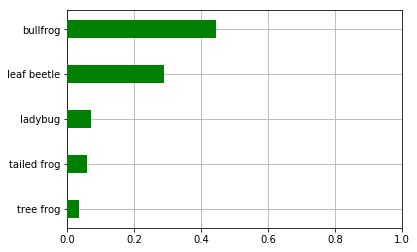

Image class: bullfrog
Predictions:
class:       bullfrog	probability:  44.44%
class:    leaf beetle	probability:  28.83%
class:        ladybug	probability:   6.95%
class:    tailed frog	probability:   5.75%
class:      tree frog	probability:   3.34%

Match!


In [9]:
# Softmax
out = utils.softmax(fct_out)

# Top-5 results
topn =  utils.get_topn_indexes(out, 5)  

x_pos = np.arange(len(topn))
plt.barh(x_pos, out[topn], height=0.4, color='g', zorder=3)
plt.yticks(x_pos, [names[k] for k in topn])
plt.gca().invert_yaxis()
plt.xlim([0,1])
plt.grid(zorder=0)
plt.show()

if img_class in synsets.keys():
    print("Image class: {:>5}\nPredictions:".format(synsets[img_class]))
    for k in topn: print("class:{0:>15}\tprobability:{1:>8.2%}".format(names[k].lower(), out[k]))
    if synsets[img_class] in (names[k] for k in topn):
        print("\nMatch!")
else:    
    for k in topn: print("class:{0:>20}\tprobability:{1:>8.2%}".format(names[k].lower(), out[k]))
        


## 8. Performance evaluation
Show the performance of both software and hardware execution in terms of execution time, number of operations and number of operations over time.
The software execution includes the first convolutional layer and the fully connected layers, while the hardware execution includes all the offloaded convolutional layers

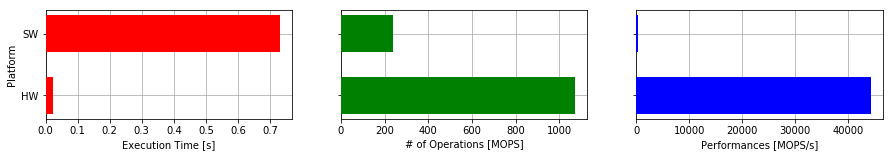

In [10]:
array = np.loadtxt('timestamp.txt')
array = list(map(lambda x: x/1000000, array))

MOPS   = [238.176256, 1073.856969]
TIME   = [array[0] + array[2], array[1]]
MOPSS  = [m / t for (m, t) in zip(MOPS ,TIME)]
LABELS = ['SW', 'HW']

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,2))
x_pos = np.arange(len(LABELS))
plt.yticks(x_pos, LABELS)

ax1.barh(x_pos, TIME, height=0.6, color='r', zorder=3)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time [s]")
ax1.set_ylabel("Platform")
ax1.grid(zorder=0)

ax2.barh(x_pos, MOPS, height=0.6, color='g', zorder=3)
ax2.invert_yaxis()
ax2.set_xlabel("# of Operations [MOPS]")
ax2.grid(zorder=0)

ax3.barh(x_pos, MOPSS, height=0.6, color='b', zorder=3)
ax3.invert_yaxis()
ax3.set_xlabel("Performances [MOPS/s]")
ax3.grid(zorder=0)

plt.show() 

## Reset the device

In [11]:
classifier.deinit_accelerator()

In [12]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()